In [129]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
#import plotly.plotly as py
#import plotly.graph_objs as go
#plotly.__version__
#plotly.tools.set_credentials_file(username='jordanvi', api_key='eWMeFHaplpUZvrjlAUZ9')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [130]:
from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

air_reserve.csv.zip
air_store_info.csv.zip
air_visit_data.csv.zip
date_info.csv.zip
hpg_reserve.csv.zip
hpg_store_info.csv.zip
sample_submission.csv.zip
store_id_relation.csv.zip



In [131]:
# Loading data
data = {
    'train': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'air_store_info': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hpg_store_info': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'air_reserve': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hpg_reserve': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'store_id_relation': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'test': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'date_info': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

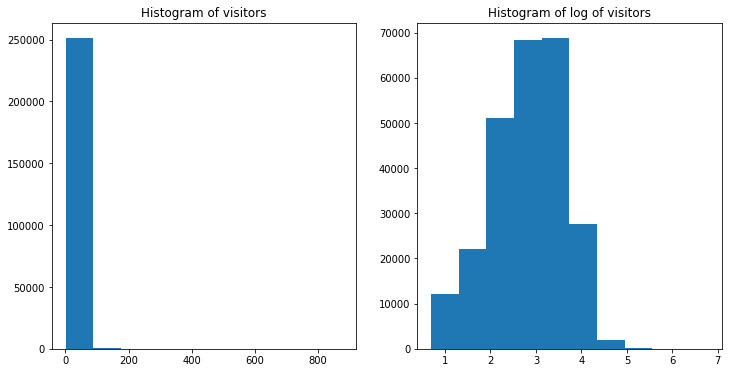

In [132]:
plt.subplots(figsize=(12,6))
plt.subplot(1, 2, 1)
data['train']['visitors'].hist()
plt.title('Histogram of visitors')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Histogram of log of visitors')
data['train']['visitors'].map(pd.np.log1p).hist()
plt.grid(False)

In [133]:
# bring air id to hpg reserve data
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['store_id_relation'], how='inner', on=['hpg_store_id'])
# bring air id to hpg stores
data['hpg_store_info'] = pd.merge(data['hpg_store_info'], data['store_id_relation'], how='inner', on=['hpg_store_id'])

### Time Series of dataset

In [128]:
#converting datetime to date for reservation data
for df in ['air_reserve','hpg_reserve']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour
    data[df]['visit_date'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    #data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    #data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour
    data[df]['reserve_date'] = data[df]['reserve_datetime'].dt.date
    #tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    #tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    
    #data[df+'_hour'] = data[df]#keeping original
    
    #calculate reserve time difference and summarizing air_reserve,hpg_reserve to date
    data[df]['reserve_day_'+df] = data[df].apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_date'], as_index=False)[[
        'reserve_day_'+df, 'reserve_visitors']].sum().rename(columns={'reserve_visitors':'reserve_visitors_'+df})

KeyError: 'visit_datetime'

In [77]:
#breaking down dates on training data & summarizing 
data['train']['visit_date'] = pd.to_datetime(data['train']['visit_date'])
data['train']['day'] = data['train']['visit_date'].dt.day
data['train']['dow'] = data['train']['visit_date'].dt.weekday
#data['train']['dow_name'] = data['train']['visit_date'].dt.weekday_name
data['train']['year'] = data['train']['visit_date'].dt.year
data['train']['month'] = data['train']['visit_date'].dt.month
data['train']['week'] = data['train']['visit_date'].dt.week
data['train']['quarter'] = data['train']['visit_date'].dt.quarter
data['train']['visit_date'] = data['train']['visit_date'].dt.date
#data['train']['year_mth'] = data['train']['year'].astype(str)+'-'+data['train']['month'].astype(str)

In [78]:
#extracting store id and date info from test data
data['test']['air_store_id'] = data['test']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['test']['visit_date'] = data['test']['id'].map(lambda x: str(x).split('_')[2])
data['test']['visit_date'] = pd.to_datetime(data['test']['visit_date'])
data['test']['day'] = data['test']['visit_date'].dt.day
data['test']['dow'] = data['test']['visit_date'].dt.weekday
#data['test']['dow_name'] = data['test']['visit_date'].dt.weekday_name
data['test']['year'] = data['test']['visit_date'].dt.year
data['test']['month'] = data['test']['visit_date'].dt.month
data['test']['week'] = data['test']['visit_date'].dt.week
data['test']['quarter'] = data['test']['visit_date'].dt.quarter
data['test']['visit_date'] = data['test']['visit_date'].dt.date
#data['test']['year_mth'] = data['test']['year'].astype(str)+'-'+data['test']['month'].astype(str)

In [64]:
data['test'] = data['test'].drop(['id'], axis=1)

### FE

In [79]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['test']['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [80]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['train'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['test'].groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

tmp = data['train'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

tmp = data['test'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# map stores(test) to store genre and location detail
store_7days = pd.merge(store_7days, data['air_store_info'], how='left', on=['air_store_id']) 
#map to hpg genre and area
store_7days = pd.merge(store_7days, data['hpg_store_info'][['air_store_id','hpg_genre_name','hpg_area_name']], 
                       how='left', on=['air_store_id']) 

data['date_info']['visit_date'] = pd.to_datetime(data['date_info']['visit_date'])
data['date_info']['visit_date'] = data['date_info']['visit_date'].dt.date

hf=data['date_info']['holiday_flg']
dw=data['date_info']['day_of_week']
data['date_info']['long_wknd']=0

In [81]:
store_7days.shape

(5747, 18)

In [82]:
for i in range(len(data['date_info'])):
    if (hf[i]==1)&(dw[i]=='Friday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i+1]=1
        data['date_info']['long_wknd'][i+2]=1
          
    if (hf[i]==1)&(dw[i]=='Monday'):
        data['date_info']['long_wknd'][i]=1
        data['date_info']['long_wknd'][i-1]=1
        data['date_info']['long_wknd'][i-2]=1

/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jordanvidal/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [83]:
train = pd.merge(data['train'], data['date_info'], how='left', on=['visit_date']) 
test = pd.merge(data['test'], data['date_info'], how='left', on=['visit_date']) 
train = pd.merge(train, store_7days, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, store_7days, how='left', on=['air_store_id','dow'])

In [84]:
for df in ['air_reserve','hpg_reserve']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [85]:
train = train.fillna(1) #change to one for algo training
test = test.fillna(0)
train['v_no_reservation']=train['visitors']-train['reserve_visitors_air_reserve']-train['reserve_visitors_hpg_reserve']
test['v_no_reservation']=test['visitors']-test['reserve_visitors_air_reserve']-test['reserve_visitors_hpg_reserve']

In [86]:
train.shape

(252108, 33)

In [87]:
test.shape

(32019, 34)

In [88]:
le = LabelEncoder()
#train3['air_store_id'] = le.fit_transform(train3['air_store_id'])
#test3['air_store_id'] = le.fit_transform(test3['air_store_id'])
le.fit(train['air_store_id'])

LabelEncoder()

In [89]:
train['air_store_id'] = le.transform(train['air_store_id'])
test['air_store_id'] = le.transform(test['air_store_id'])

In [90]:
train = pd.get_dummies(data=train, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])
test = pd.get_dummies(data=test, columns=['air_genre_name', 'air_area_name','hpg_genre_name','hpg_area_name'])

In [91]:
train.dtypes

air_store_id                                                     int64
visit_date                                                      object
visitors                                                         int64
day                                                              int64
dow                                                              int64
year                                                             int64
month                                                            int64
week                                                             int64
quarter                                                          int64
day_of_week                                                     object
holiday_flg                                                      int64
long_wknd                                                        int64
total_visitors_x                                               float64
total_visitors_y                                               float64
mean_v

In [92]:
train = train.drop(['visit_date','day_of_week','air_genre_name_1','air_area_name_1'], axis=1)
test = test.drop(['visit_date','day_of_week'], axis=1)

### START MODELLING

In [93]:
y = train.pop('visitors')

In [94]:
train.shape

(252108, 194)

In [95]:
test.shape

(32019, 196)

In [96]:
# split data into train and test sets
#seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size)

In [97]:
from sklearn import feature_selection

In [98]:
f = feature_selection.f_regression(X_train, y_train)

### random forest

In [99]:
#RF apres FE
rf = RandomForestRegressor()
model2 = rf.fit(X_train, y_train)
predictions2 = rf.predict(X_test)

importances = rf.feature_importances_

Feature ranking:
1. feature 25 (0.869760)
2. feature 22 (0.108510)
3. feature 24 (0.009580)
4. feature 15 (0.007975)
5. feature 27 (0.000706)
6. feature 126 (0.000491)
7. feature 9 (0.000467)
8. feature 20 (0.000449)
9. feature 3 (0.000374)
10. feature 21 (0.000239)
11. feature 23 (0.000185)
12. feature 11 (0.000140)
13. feature 2 (0.000139)
14. feature 13 (0.000137)
15. feature 5 (0.000100)
16. feature 0 (0.000088)
17. feature 17 (0.000074)
18. feature 1 (0.000073)
19. feature 19 (0.000062)
20. feature 29 (0.000051)
21. feature 4 (0.000043)
22. feature 6 (0.000041)
23. feature 160 (0.000035)
24. feature 30 (0.000021)
25. feature 51 (0.000020)
26. feature 168 (0.000018)
27. feature 8 (0.000014)
28. feature 7 (0.000014)
29. feature 40 (0.000010)
30. feature 26 (0.000009)
31. feature 63 (0.000009)
32. feature 114 (0.000008)
33. feature 33 (0.000008)
34. feature 186 (0.000008)
35. feature 153 (0.000007)
36. feature 18 (0.000007)
37. feature 34 (0.000007)
38. feature 66 (0.000007)
39. feat

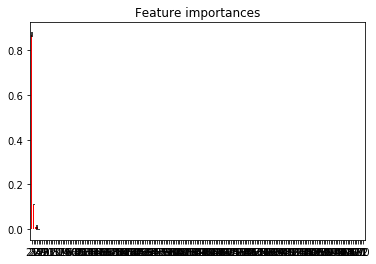

In [100]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### linear regression

In [101]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

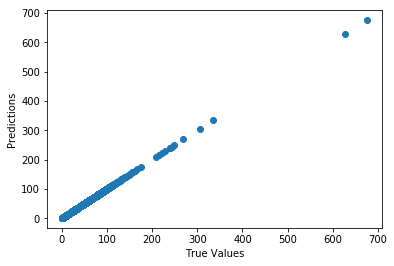

In [102]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [103]:
print('Score:', model.score(X_test, y_test))

Score: 1.0


In [104]:
print(mean_absolute_error(np.array(y_test), predictions))

1.56272720184e-12


In [107]:
#accuracy_score(y_true, y_pred)

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.0000 +/-0.0000


### RF before FE

In [40]:
#data['test'] = data['test'].drop(['air_store_id'], axis=1)
data['train'] = data['train'].drop(['air_store_id'], axis=1)
data['train']['visit_date'] = pd.to_datetime(data['train']['visit_date'])
data['test']['visit_date'] = pd.to_datetime(data['test']['visit_date'])
data['train'] = data['train'].drop(['visit_date'], axis=1)
data['test'] = data['test'].drop(['visit_date'], axis=1)
#data['train'] = data['train'].drop(['year_mth'], axis=1)
#data['test'] = data['test'].drop(['year_mth'], axis=1)

y = data['train'].pop('visitors')
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data['train'], y, test_size=test_size, random_state=seed)
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[0:10]
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Linear Regression Score:", lm.score(X_test, y_test))

rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

f_rf = feature_selection.f_regression(X_train, y_train)



ValueError: labels ['air_store_id'] not contained in axis

In [ ]:
y = data['train'].pop('visitors')
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data['train'], y, test_size=test_size, random_state=seed)
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[0:10]
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Linear Regression Score:", lm.score(X_test, y_test))

rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)

f_rf = feature_selection.f_regression(X_train, y_train)